In [1]:
import torch 
import torch_geometric
from torch_geometric.loader import DataLoader
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, max_error
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
from tqdm import tqdm
from dataset import *
from model import *
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import plotly.express as px
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cpu")

In [2]:
torch_geometric.seed_everything(23)

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
data = MoC_c_dir(root ='/Users/ed_aguilar/Documents/PhD_Documents/Experiments/Metal_carbides/Experiments_periodicity/NewData/Data', max_d = 3.2, max_n = 26)
print("Dataset type: ", type(data))
print("Dataset node features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)

Dataset type:  <class 'dataset.MoC_c_dir'>
Dataset node features:  5
Dataset target:  977
Dataset length:  <bound method MoC_c_dir.len of MoC_c_dir(1042)>
Dataset sample:  Data(x=[48, 5], edge_index=[2, 658], edge_attr=[658, 6], y=[1], file_idx='1', file_name='luis_594.vasp')
Sample  nodes:  48
Sample  edges:  658


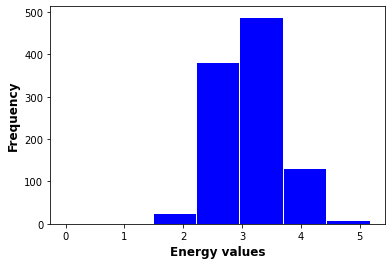

In [5]:
plt.plot(figsize =(12, 8))
plt.hist([torch.squeeze(data[i].y) for i in range(len(data))], bins = 7, color = 'blue', edgecolor='white')
plt.xlabel('Energy values', fontweight ='bold', fontsize = 12)
plt.ylabel('Frequency', fontweight ='bold', fontsize = 12)
plt.show()

In [6]:
x = [data[i].x.numpy() for i in range(data.len())]
x = np.array(x)
y = [data[i].y.numpy() for i in range(data.len())]
y = np.array(y)

In [7]:
limits = np.linspace(np.min(y), np.max(y), num=8)
y_cat = [0]*len(y)
y_cat = np.expand_dims(y_cat, axis = 1)
y_cat = np.array(y_cat)

In [8]:
y_cat[np.where((y >= limits[0]) & (y <limits[1]))[0]] = 0
y_cat[np.where((y >= limits[1]) & (y <limits[2]))[0]] = 1
y_cat[np.where((y >= limits[2]) & (y <limits[3]))[0]] = 2
y_cat[np.where((y >= limits[3]) & (y <limits[4]))[0]] = 3
y_cat[np.where((y >= limits[4]) & (y <limits[5]))[0]] = 4
y_cat[np.where((y >= limits[5]) & (y <limits[6]))[0]] = 5
y_cat[np.where((y >= limits[6]) & (y <= limits[7]))[0]] = 6
y_cat = y_cat.astype(int)

In [9]:
folds = StratifiedKFold(n_splits=5, shuffle=True)
train_idx = []
test_idx = []

for i, (train, test) in enumerate(folds.split(x, y_cat)):
    train_idx.append(train)
    test_idx.append(test)

In [10]:
model = GCN_loop(data.num_features, embedding_size = 64, gnn_layers = 3, improved=False)
#model = GAT_original(data.num_features, embedding_size = 32, heads = 2)
print(model)
print(model.forward)
print("Number of parameters: ", count_parameters(model))

GCN_loop(
  (initial_conv): GCNConv(5, 64)
  (conv_layers): ModuleList(
    (0-1): 2 x GCNConv(64, 64)
  )
  (out): Linear(in_features=128, out_features=1, bias=True)
)
<bound method GCN_loop.forward of GCN_loop(
  (initial_conv): GCNConv(5, 64)
  (conv_layers): ModuleList(
    (0-1): 2 x GCNConv(64, 64)
  )
  (out): Linear(in_features=128, out_features=1, bias=True)
)>
Number of parameters:  8833


In [11]:
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimiser, gamma = 0.995)

In [12]:
kfold_idx = 4

In [13]:
train_loader = DataLoader(data[train_idx[kfold_idx]], batch_size = 20, shuffle = True) 
test_loader = DataLoader(data[test_idx[kfold_idx]], batch_size = 10, shuffle = False) 

In [14]:
test_idx[kfold_idx]

array([   1,    3,    5,   13,   15,   26,   28,   49,   51,   52,   62,
         72,   74,   78,   79,   88,   89,   91,   94,   97,  104,  117,
        119,  120,  131,  135,  140,  141,  143,  144,  147,  149,  157,
        173,  179,  183,  189,  204,  214,  222,  228,  232,  244,  245,
        246,  254,  258,  263,  271,  276,  277,  281,  286,  290,  295,
        296,  298,  306,  310,  312,  333,  337,  338,  343,  344,  345,
        348,  351,  353,  357,  363,  365,  371,  376,  379,  383,  388,
        390,  400,  401,  404,  408,  409,  410,  412,  421,  428,  434,
        436,  439,  440,  451,  455,  457,  462,  464,  465,  467,  470,
        479,  480,  491,  494,  499,  510,  521,  522,  526,  528,  529,
        538,  549,  554,  557,  559,  567,  570,  585,  590,  591,  593,
        595,  596,  613,  616,  622,  626,  630,  632,  644,  652,  659,
        663,  666,  667,  670,  673,  680,  682,  685,  688,  689,  692,
        699,  702,  704,  714,  715,  718,  721,  7

In [15]:
train_y = [data[train_idx[kfold_idx]][i].y for i in range(len(data[train_idx[kfold_idx]]))]
test_y = [data[test_idx[kfold_idx]][i].y for i in range(len(data[test_idx[kfold_idx]]))]

print(f'The minimum training value is: {min(train_y)}, and the maximum is {max(train_y)}')
print(f'The minimum test value is: {min(test_y)}, and the maximum is {max(test_y)}')

The minimum training value is: tensor([0.], dtype=torch.float64), and the maximum is tensor([5.1743], dtype=torch.float64)
The minimum test value is: tensor([0.9989], dtype=torch.float64), and the maximum is tensor([4.8013], dtype=torch.float64)


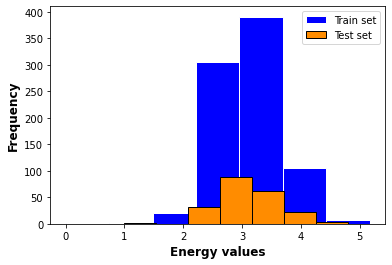

In [17]:
plt.plot(figsize = (24,16))
plt.hist(y[train_idx[kfold_idx]], 7, color = 'blue', label='Train set', edgecolor='white')
plt.hist(y[test_idx[kfold_idx]], 7, color = 'darkorange', label='Test set', edgecolor='black')
plt.xlabel('Energy values', fontweight ='bold', fontsize = 12)
plt.ylabel('Frequency', fontweight ='bold', fontsize = 12)
plt.legend()
plt.show()

In [17]:
def train(epoch):

    all_preds = []
    all_y = []
    total_loss = 0
    step = 0

    for batch in train_loader:

        # Use GPU
        batch.to(device)

        # Reset gradients
        optimiser.zero_grad()

        # Passing the node features and the connection info
        pred = model(batch.x,  
                        batch.edge_index,
                        batch.batch)
        
        # Calculating the loss and gradients
        loss = torch.sqrt(loss_fn(pred, torch.unsqueeze(batch.y.float(), dim = 1)))
        loss.backward()

        # Update using the gradients
        optimiser.step() 

        total_loss += loss.item()
        step += 1

        all_preds.append(pred.cpu().detach().numpy())
        all_y.append(batch.y.cpu().detach().numpy())
    
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate (all_y).ravel() 


    return torch.tensor(total_loss/step), all_preds, all_labels

In [18]:
def test (epoch):
    
    all_preds = []
    all_labels = []
    total_loss = 0
    step = 0

    for batch in test_loader:

        batch.to(device)
        pred = model(batch.x,  
                        batch.edge_index, 
                        batch.batch)
        
        loss = torch.sqrt(loss_fn(pred, torch.unsqueeze(batch.y.float(), dim = 1)))

        total_loss += loss.item()
        step += 1

        all_preds.append(pred.cpu().detach().numpy())
        all_labels.append(batch.y.cpu().detach().numpy())

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()

    return torch.tensor(total_loss/step), all_preds, all_labels

In [19]:
loss_train = []
loss_test = []

pred_train = []
pred_test = []

labels_train = []
labels_test = []

epochs = 701


for epoch in range (epochs):
            # Training
            model.train()
            loss, pred, label = train(epoch=epoch)
            loss = loss.detach().cpu().numpy()

            if epoch % 5 == 0:
                loss_train.append(loss) 

            if epoch % 100 == 0:
                   print(f"Epoch {epoch} | Train Loss {loss}")
                   pred_train.append(pred)
                   labels_train.append(label)

            # Testing
            model.eval()
            if epoch % 5 == 0:
                loss, pred, label = test(epoch=epoch)
                loss = loss.detach().cpu().numpy() 

                if epoch % 10 == 0:
                    loss_test.append(loss)

                if epoch % 100 == 0:
                    print(f"Epoch {epoch} | Test Loss {loss}")
                    pred_test.append(pred)
                    labels_test.append(label)

            scheduler.step()



Epoch 0 | Train Loss 0.9865320920944214
Epoch 0 | Test Loss 0.5309197902679443
Epoch 100 | Train Loss 0.41317594051361084
Epoch 100 | Test Loss 0.40857744216918945
Epoch 200 | Train Loss 0.3261798620223999
Epoch 200 | Test Loss 0.30013933777809143
Epoch 300 | Train Loss 0.26213935017585754
Epoch 300 | Test Loss 0.2446940392255783
Epoch 400 | Train Loss 0.21384720504283905
Epoch 400 | Test Loss 0.22058990597724915
Epoch 500 | Train Loss 0.17077583074569702
Epoch 500 | Test Loss 0.22403067350387573
Epoch 600 | Train Loss 0.14849820733070374
Epoch 600 | Test Loss 0.21291430294513702
Epoch 700 | Train Loss 0.13524633646011353
Epoch 700 | Test Loss 0.2202824354171753


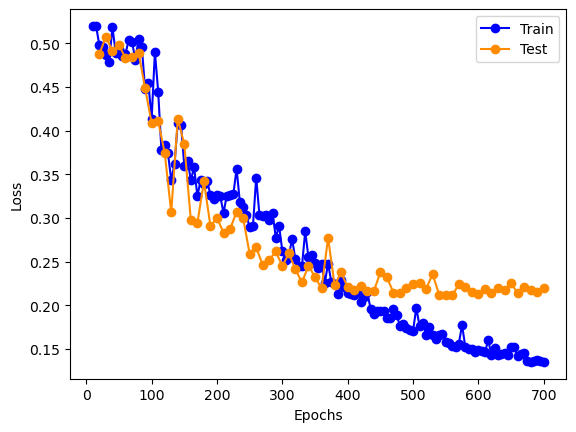

In [20]:
n=2
plt.plot(range(0,epochs,5)[n:], loss_train[n:], 'o-', label = 'Train', color = 'blue')
plt.plot(range(0,epochs,10)[n:], loss_test[n:], 'o-', label = 'Test', color = 'darkorange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

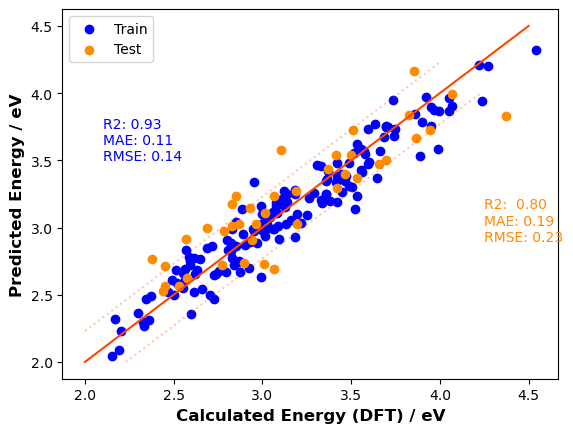

In [21]:
e = 7

plt.scatter(labels_train[e], pred_train[e], color = 'blue', label = 'Train')
plt.scatter(labels_test[e], pred_test[e], color = 'darkorange', label = 'Test')
plt.xlabel("Calculated Energy (DFT) / eV", fontweight ='bold', fontsize = 12)
plt.ylabel("Predicted Energy / eV", fontweight ='bold', fontsize = 12)
plt.legend()

plt.plot( [2, 4],[2+.23, 4+.23], color = 'orangered', ls = ':', alpha = .3 )
plt.plot( [2, 4.5],[2, 4.5], color = 'orangered' )
plt.plot( [2+.23, 4+.23],[2, 4], color = 'orangered', ls = ':', alpha = .3 )

plt.text(2.1, 3.5, f'R2: {pearsonr(labels_train[e], pred_train[e])[0]**2:.2f} \n\
MAE: {mean_absolute_error(labels_train[e], pred_train[e]):.2f} \n\
RMSE: {sqrt(mean_squared_error(labels_train[e], pred_train[e])):.2f}', color = 'b')

plt.text(4.25, 2.9, f'R2:  {pearsonr(labels_test[e], pred_test[e])[0]**2:.2f}\n\
MAE: {mean_absolute_error(labels_test[e], pred_test[e]):.2f} \n\
RMSE: {sqrt(mean_squared_error(labels_test[e], pred_test[e])):.2f}', color = 'darkorange')
plt.show()

In [22]:
from torch_geometric.explain import Explainer, GNNExplainer

In [23]:
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='graph',
        return_type='probs',
    ),
)

In [24]:
explain = DataLoader(data[test_idx[0]])
mol = next(iter(explain))
mol

DataBatch(x=[48, 5], edge_index=[2, 658], edge_attr=[658, 6], y=[1], batch=[48], ptr=[2])

In [25]:
explanation = explainer(x = mol.x, edge_index=mol.edge_index,  batch_index=mol.batch)

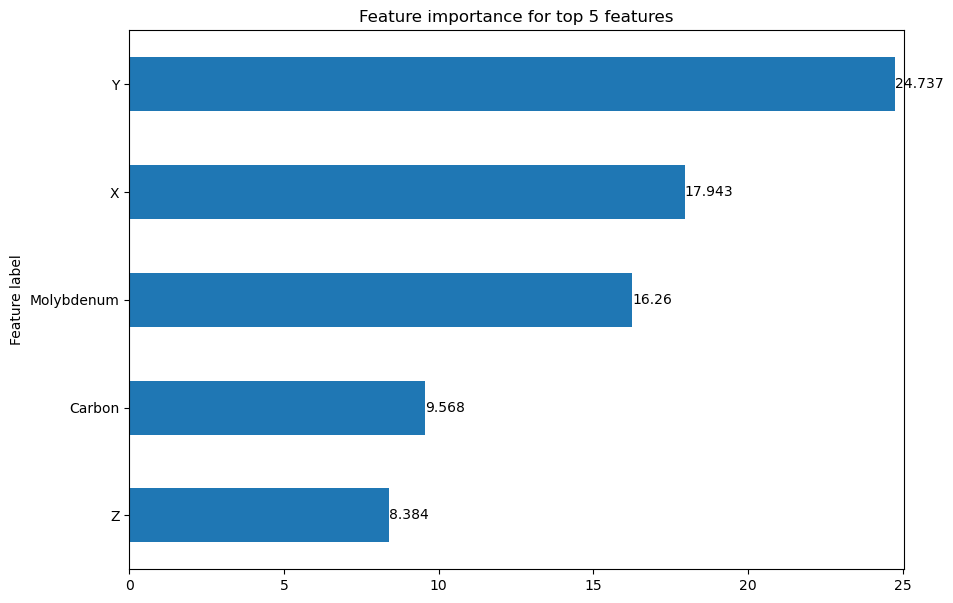

In [26]:
explanation.visualize_feature_importance(path=None, top_k=5, feat_labels = ['Molybdenum', 'Carbon', 'X', 'Y', 'Z'])

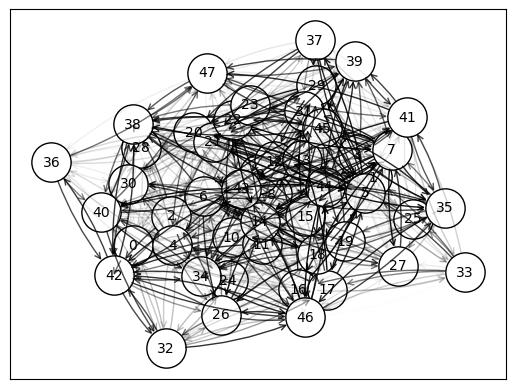

In [27]:
explanation.visualize_graph(None)

In [28]:
import networkx as nx
from torch_geometric.utils import to_networkx
import plotly.graph_objects as go

In [29]:
def to_molecule(data):
    coords = {}
    ATOM_MAP = {1:'Mo', 0: 'C'}
    
    g = to_networkx(data, node_attrs=['x'])

    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'][0]]
        coords[u] = np.array([data['x'][2],data['x'][3],data['x'][4]])
        data['an'] = u
        if data['x'][4] < 1:
            data['Layer'] = '0'
        elif data['x'][4] < 3:
            data['Layer'] = '1'
        elif data['x'][4] < 5:
            data['Layer'] = '2'
        else:
            data['Layer'] = '3'
        
        del data['x']
    return g, coords

In [30]:
structure = data[test_idx[4]][26]
G, pos = to_molecule(structure)

In [31]:
C = nx.Graph()
Mo = nx.Graph()
for u, feat in G.nodes(data = True):
    if feat['name'] == 'Mo':
        Mo.add_node(u, name = feat['name'], Layer = feat['Layer'], an = feat['an'])
    if feat['name'] == 'C':
        C.add_node(u, name = feat['name'], Layer = feat['Layer'], an = feat['an'])

In [32]:
Mo_xyz = np.array([pos[v] for v in sorted(Mo)])
C_xyz = np.array([pos[v] for v in sorted(C)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])
Mo_an = [an for an in sorted(Mo)]
C_an = [an for an in sorted(C)]

In [33]:
trace_Mo = go.Scatter3d(
    x=Mo_xyz[:,0],
    y=Mo_xyz[:,1],
    z=Mo_xyz[:,2],
    mode='markers',
    text = 'Molybdenum',
    marker=dict(symbol='circle',
            size=10,
            color='aliceblue')
    )

trace_C = go.Scatter3d(
    x=C_xyz[:,0],
    y=C_xyz[:,1],
    z=C_xyz[:,2],
    mode='markers',
    text = 'Carbon',
    marker=dict(symbol='circle',
            size=5,
            color='darkturquoise')
    )


trace_edges = [None] * len(edge_xyz)

for i in range(len(edge_xyz)):

    trace_edges[i]= go.Scatter3d(
        x=edge_xyz[i,:,0],
        y=edge_xyz[i,:,1],
        z=edge_xyz[i,:,2],
        text=' ',
        mode='lines',
        line=dict(color='black', width=1),
        hoverinfo='none')

traces = trace_edges + [trace_Mo, trace_C]
fig = go.Figure(data=traces)

fig.show()

In [34]:
from captum.attr import Saliency, IntegratedGradients

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x, data.edge_index, batch, edge_mask)
    return out


def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask

In [35]:
from collections import defaultdict

In [36]:
def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *data.edge_index)):
        u, v = u.item(), v.item()
        edge_mask_dict[(u, v)] += val

    return edge_mask_dict

In [37]:
edge_mask = explain('ig', structure, target=0)
edge_mask_dict = aggregate_edge_directions(edge_mask, structure)

In [38]:
for u, v in edge_mask_dict:
    edge_mask_dict[(u, v)] += edge_mask_dict[(v, u)] 
    edge_mask_dict[(v, u)] = edge_mask_dict[(u, v)]

In [39]:
weights = list(edge_mask_dict.values())
weights = (weights - min(weights))/(max(weights)- min(weights))

In [40]:
edges = list(edge_mask_dict.keys())

In [41]:
trace_Mo = go.Scatter3d(
    x=Mo_xyz[:,0],
    y=Mo_xyz[:,1],
    z=Mo_xyz[:,2],
    mode='markers',
    text = Mo_an,
    name = 'Molybdenum',
    marker=dict(symbol='circle',
            size=10,
            color='dimgrey')
    )

trace_C = go.Scatter3d(
    x=C_xyz[:,0],
    y=C_xyz[:,1],
    z=C_xyz[:,2],
    mode='markers',
    text = C_an,
    name = 'Carbon',
    marker=dict(symbol='circle',
            size=5,
            color='black')
    )


trace_edges = [None] * len(edge_xyz)

for i in range(int(len(edge_xyz))):
    trace_edges[i]= go.Scatter3d(
        x=edge_xyz[i,:,0],
        y=edge_xyz[i,:,1],
        z=edge_xyz[i,:,2],
        name= f'atom{edges[i][0]}-atom{edges[i][1]}',
        mode='lines',
        opacity=weights[i],
        line=dict(color='red', width=weights[i]*7.5),
        hoverinfo='none')

traces = [trace_Mo, trace_C] + trace_edges 
fig = go.Figure(data=traces)

fig.show()